successfully loaded 17166 entries


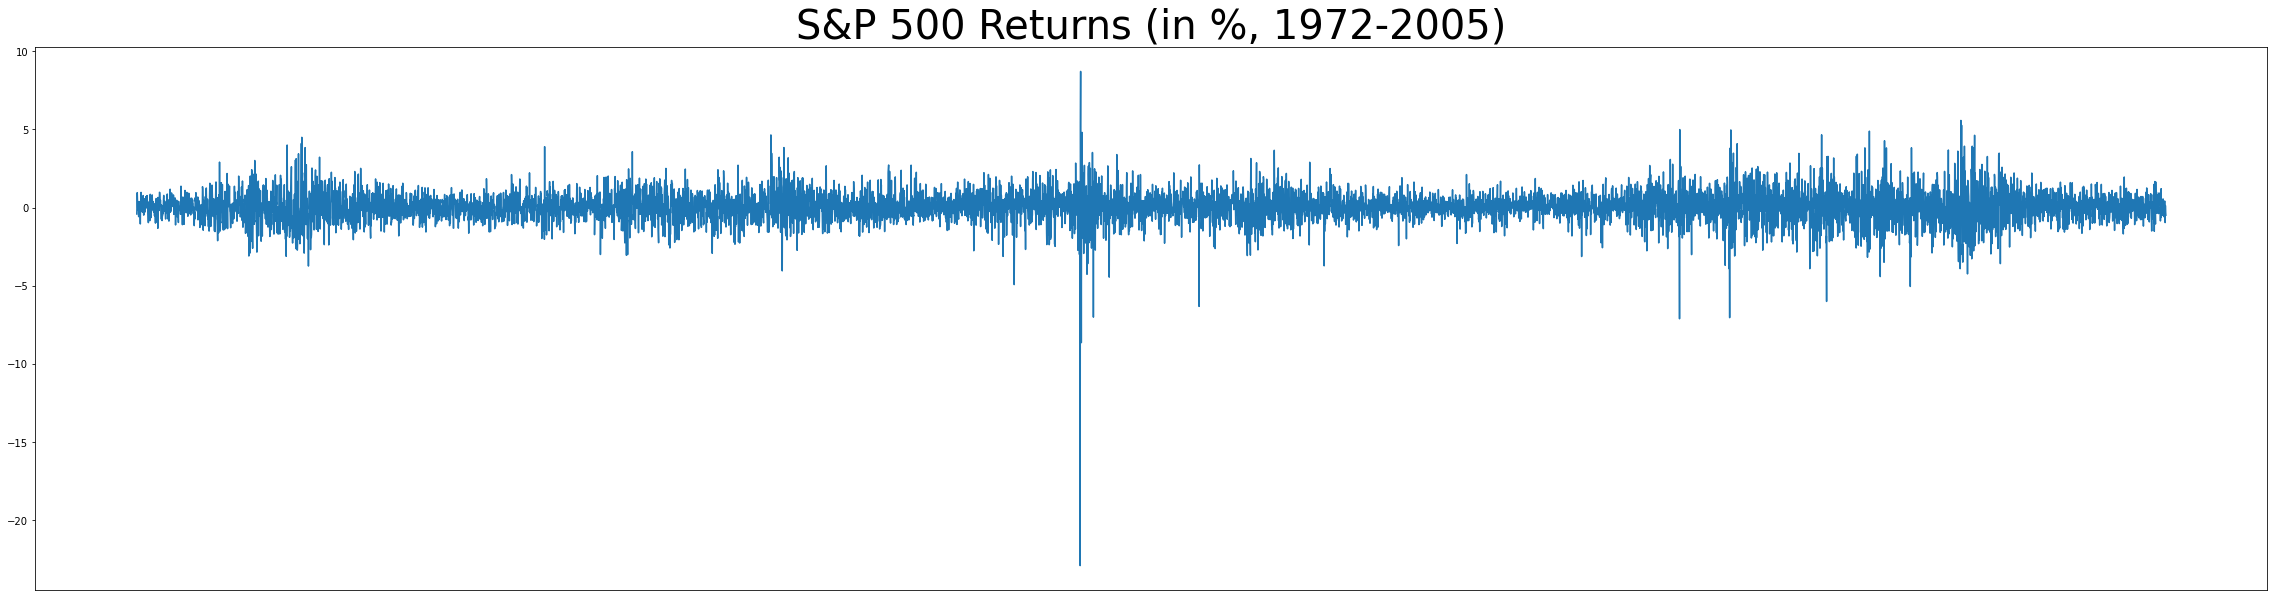

Calculating Metropolis-Hastings random walk...


/Users/wchen/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


iter: 500
iter: 1000
iter: 1500
iter: 2000
iter: 2500
iter: 3000
iter: 3500
iter: 4000
iter: 4500
iter: 5000
iter: 5500
iter: 6000
iter: 6500
iter: 7000
iter: 7500
iter: 8000
iter: 8500
iter: 9000
iter: 9500
iter: 10000
iter: 10500
iter: 11000
iter: 11500
iter: 12000
iter: 12500
iter: 13000
iter: 13500
iter: 14000
iter: 14500
iter: 15000
writing model parameters to file...


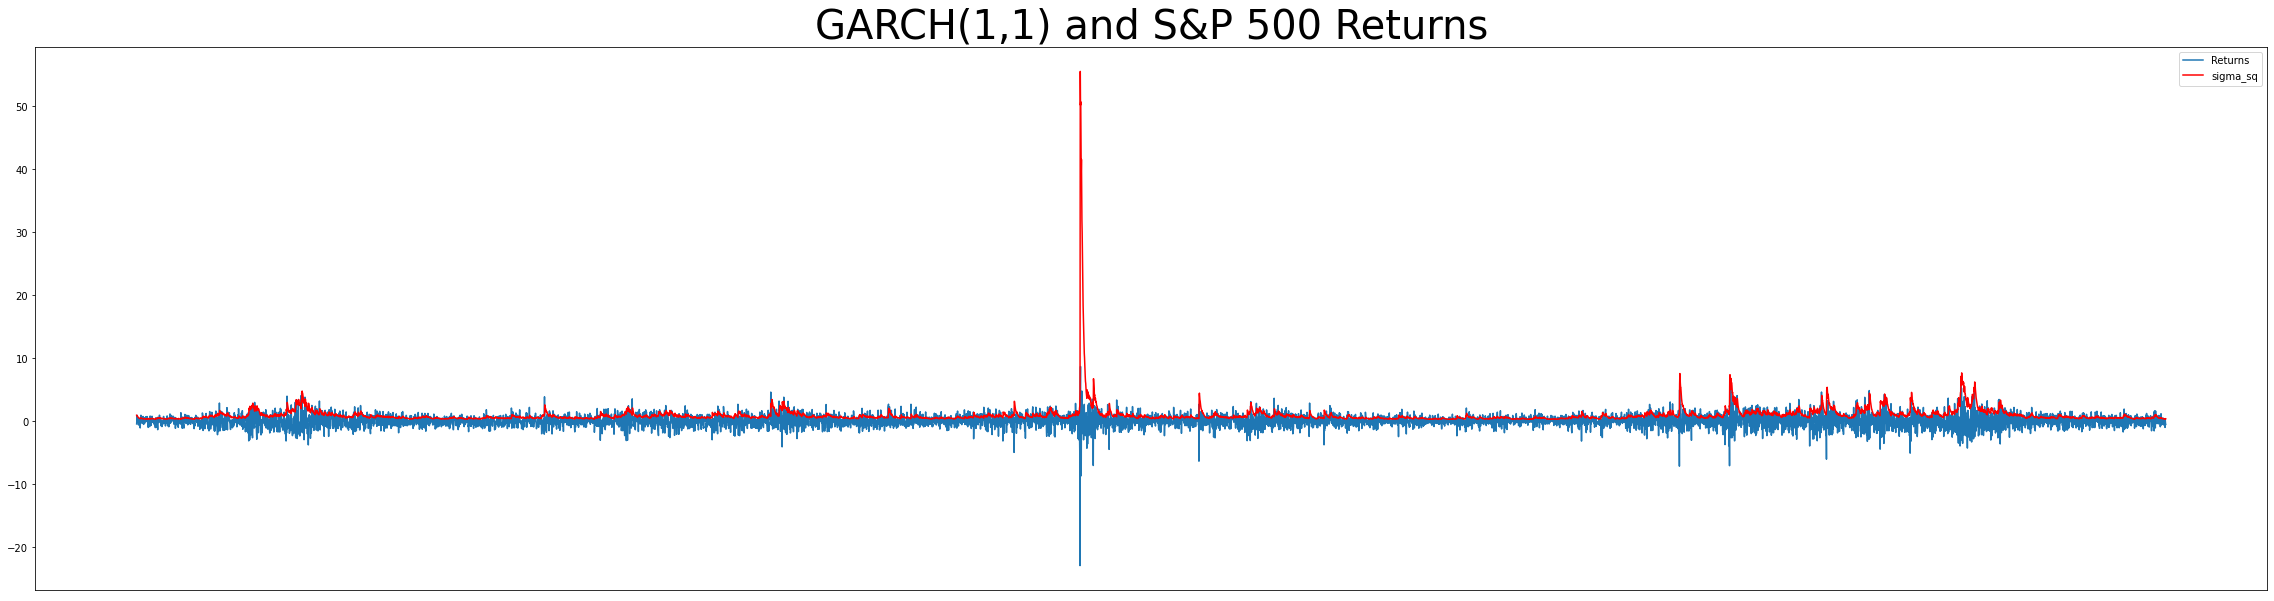

plotting posterior parameters...


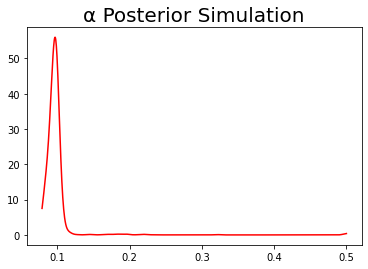

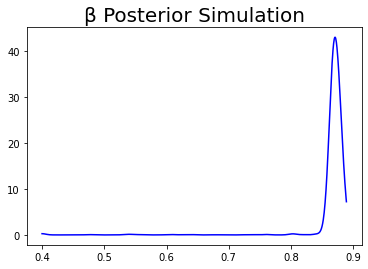

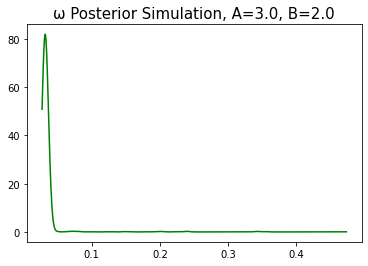

'\nhave sample of draws of posterior estimate\n\nuse first 80% of draws to estimate model\n\nuse remaining 20% to do predictive analysis\n\n(split up data into test and training)\n\n\ncompute vector of sigma average when computing likelihood\naverage sigma_t for every t\nplot it versus data\n\ncompare with ARCH model ???\ncompute log-score\n\n'

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

NUM_ITERS = 15000
BURN_IN = 400

HIGH_ACCEPT_THRESHOLD = 0.8
LOW_ACCEPT_THRESHOLD = 0.2

LOAD = False
PREDICTIVE = False

SIGMA_PATH = "../data/sigma_sq_15k.txt"
OMEGA_PATH = "../data/omega_15k.txt"
ALPHA_PATH = "../data/alpha_15k.txt"
BETA_PATH = "../data/beta_15k.txt"

class MetropolisHastingsGARCH:
    
    def __init__(self, num_iters, burn_in, returns):
        self.NUM_ITERS = num_iters # simulation iterations post-burn-in
        self.BURN_IN = burn_in # burn-in iterations 
        self.TOTAL_SIM_ITERS = self.NUM_ITERS + self.BURN_IN # total simulation iterations
        self.PROG_LOG_STEP = 100 # how often to log progress
        
        # set returns
        self.returns = returns
        
        # simulation value arrays
        self.sim_omega = np.zeros(self.TOTAL_SIM_ITERS)
        self.sim_alpha = np.zeros(self.TOTAL_SIM_ITERS)
        self.sim_beta = np.zeros(self.TOTAL_SIM_ITERS)
        
        self.avg_sigma_sq = np.zeros(len(returns))
        
        self.finished = False
        
        
    '''
    Get parameters
    '''
    def get_param_results(self):
        if not self.finished:
             raise Exception("need to run random walk before getting param results")
            
        return self.sim_omega, self.sim_alpha, self.sim_beta
        
    '''
    Only call after calling random walk, get sigma_sq array
    '''
    def get_sigma_sq_results(self):
        if not self.finished:
            raise Exception("need to run random walk before getting results")
            
        return self.avg_sigma_sq
    
    '''
    Only call after calling random walk, write params to filepaths
    '''
    def write_params_to_file(self):
        if not self.finished:
            raise Exception("need to run random walk before writing to files")
        
        print("writing model parameters to file...")
        
        np.savetxt(SIGMA_PATH, self.avg_sigma_sq)
        np.savetxt(OMEGA_PATH, self.sim_omega)
        np.savetxt(ALPHA_PATH, self.sim_alpha)
        np.savetxt(BETA_PATH, self.sim_beta)
        
        
    '''
    Prior(omega) follows an inverse gamma distribution. Choose hyperparameters 
    '''
    def log_omega_prior(self, omega, g_alpha, g_beta):
        # can look up the density ? if want to?
        g = stats.invgamma.pdf(omega, g_alpha, scale=g_beta)
        if g < 0:
            raise Exception("NEGATIVE IN LOG PRIOR OMEGA")
        return np.log(g)
    
    '''
    Prior(alpha, beta), uniform improper prior proportional to 1{alpha>0, beta>0, alpha+beta < 1}
    CONSTANT, IS NOT USED IN ACCPETANCE PROBABILITY SINCE IT CANCELS OUT
    '''
    def log_alpha_beta_prior(self):
        return 0.0
    
    
    '''
    Returns the variance expression of a GARCH(1,1) process.
    '''
    def garch_filter(self, omega, alpha, beta):
               
        # Length of log_returns
        length = len(self.returns)
        
        # Initializing an empty array
        sigma_sq = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_sq[i] = omega / (1 - alpha - beta)
            else:
                sigma_sq[i] = omega + (alpha * (self.returns[i-1]**2)) + (beta * sigma_sq[i-1])
                
        return sigma_sq
        
        
    '''
    Likelihood function, is this good?
    '''
    def log_likelihood(self, omega, alpha, beta):
        
        sigma_sq = self.garch_filter(omega, alpha, beta)
        
        log_term = 2*np.pi*sigma_sq
        
        if np.min(log_term) < 0:
            raise Exception("NEGATIVE INNER TERM IN LOG LIKELIHOOD")
        
        log_likelihood = -0.5 * np.sum(np.log(log_term) + (self.returns**2)/sigma_sq)
        
        return log_likelihood
    

    '''
    Metropolis-Hastings random walk
    '''
    def random_walk_garch(self):

        '''
        Start with an initial state, which can be any value within the parameter space.

        Choose a proposal distribution, which is a probability distribution that specifies 
        how to generate a new candidate state given the current state. 
        In the GARCH case, for parameters

        Generate a candidate state by drawing a sample from the proposal distribution.

        Compute the acceptance ratio, which is the ratio of the posterior probability of 
        the candidate state to the posterior probability of the current state.

        Accept or reject the candidate state based on the acceptance ratio. 
        If the acceptance ratio is greater than or equal to 1, 
        then accept the candidate state as the new current state. 
        If the acceptance ratio is less than 1, 
        then accept the candidate state with probability equal to the acceptance ratio, 
        otherwise reject the candidate state and keep the current state as is.

        '''
        
        '''
        %     % Alternative, random walk MH block for h
        %     h_p = normrnd(sim_h(sim-1), std_rwmh);
        %     if h_p > 0 && rand < exp((barAh-1)*log(h_p/sim_h(sim-1))-barBh*(h_p-sim_h(sim-1)))
        %         sim_h(sim) = h_p;
        %         hAccCount = hAccCount + 1;
        %     else
        %         sim_h(sim) = sim_h(sim-1);
        %     end
        %     if sim < 0.1*Nsim && floor(sim/100) == sim/100 
        %         h_acc_rate = hAccCount/sim;
        %         if h_acc_rate > 0.8, std_rwmh = std_rwmh*2;end
        %         if h_acc_rate < 0.2, std_rwmh = std_rwmh*0.5; end
        %     end
        
        
        %     if sim < 0.1*Nsim && floor(sim/100) == sim/100 
        %         h_acc_rate = hAccCount/sim;
        %         if h_acc_rate > 0.8, std_rwmh = std_rwmh*2;end
        %         if h_acc_rate < 0.2, std_rwmh = std_rwmh*0.5; end
        
        '''
        
        # parameters for priors 
        # choose based on expected mean for omega, variance not too small, LOOK AT INV GAMMA STUFF
        g_a_prior = 3.0
        g_b_prior = 2.0
        
        # start with some arbitrary var for proposals 
        var_covar_prop = np.zeros((3, 3))
        var_covar_prop[0, 0] = 0.75 # omega variance
        var_covar_prop[1, 1] = 0.5 # alpha variance
        var_covar_prop[2, 2] = 0.5 # beta variance
        
        # want acceptance in between 0.2 and 0.8
        # need to adjust proposal std 
        omega_acc_count = 0
        ab_acc_count = 0
        
        
        # initialize simulation chain in a sensible way (what's a sensible way?)
        self.sim_omega[0] = 0.1
        self.sim_alpha[0] = 0.5
        self.sim_beta[0] = 0.4
        
        
        for i in range(1, self.TOTAL_SIM_ITERS):
            
            if i % 500 == 0:
                print("iter: " + str(i))
            
            # random walk block for omega parameter
            
            # np.random.normal mvn -> size 3 with var covariance matrix 
            
            omega_b = self.sim_omega[i - 1]
            alpha_b = self.sim_alpha[i - 1]
            beta_b = self.sim_beta[i - 1]
            
            # generate candidate values from some proposal distribution q(param*| param), in this multivar normal
            means = np.asarray([omega_b, alpha_b, beta_b])
            draws = np.random.multivariate_normal(means, var_covar_prop)
            
            # grab individual proposals
            omega_p = draws[0]    
            alpha_p = draws[1]
            beta_p = draws[2]
            
            # save computed likelihoods
            ll_before = self.log_likelihood(omega_b, alpha_b, beta_b)
            
            # ----- random walk block for omega -----
            
            # see if we accept this candidate, apply omega constraint > 0
            if omega_p > 0:
                # metropolis-hastings acceptance probability
                omega_accept = np.exp((self.log_likelihood(omega_p, alpha_b, beta_b) + self.log_omega_prior(omega_p, g_a_prior, g_b_prior)) - (ll_before + self.log_omega_prior(omega_b, g_a_prior, g_b_prior)))
                if np.random.random() < omega_accept:
                    # accept the candidate
                    self.sim_omega[i] = omega_p
                    omega_acc_count += 1
                else:
                    # reject candidate, use prev value
                    self.sim_omega[i] = omega_b
            else:
                # reject candidate, use prev value
                self.sim_omega[i] = omega_b
            
            # ----- random walk block for alpha, beta parameter -----
            
            # apply alpha and beta constraints
            if alpha_p > 0 and beta_p > 0 and ((alpha_p + beta_p) < 1):
                # metropolis-hastings acceptance probability
                alpha_beta_accept = np.exp(self.log_likelihood(omega_b, alpha_p, beta_p) - ll_before)
                if np.random.random() < alpha_beta_accept: 
                    # accept the candidates
                    self.sim_alpha[i] = alpha_p
                    self.sim_beta[i] = beta_p
                    ab_acc_count += 1
                else:
                    # reject candidates, use prev values
                    self.sim_alpha[i] = alpha_b
                    self.sim_beta[i] = beta_b
            else:
                # reject candidates, use prev values
                self.sim_alpha[i] = alpha_b
                self.sim_beta[i] = beta_b
            
            # update sigma_sq averages with the accepted values
            self.avg_sigma_sq += self.garch_filter(self.sim_omega[i], self.sim_alpha[i], self.sim_beta[i])
            
            '''
            adjust correlations and relative scale when adjusting prop std
            
            first assume no covariance, values diagonal matrix, hard code
            
            run MCMC and then take into account correlation in between them
            
            after a while, have bunch of vectors of 3 draws of parameters. "sample of vectors after a while"
            compute sample variance-covariance matrix USE NP.COV
            
            have var-covar matrix to pass in
            
            can scale it by 2 or 0.5 depending on accuracy of reject/accept
            '''
            # adjust variance-covariance matrix every so often in the beginning
            if i < (self.TOTAL_SIM_ITERS / 10) and (i % 100) == 0:
                
                # recalc cov matrix using all the samples we have so far
                var_covar_prop = np.cov(np.vstack((self.sim_omega[:i+1], self.sim_alpha[:i+1], self.sim_beta[:i+1])))
                
                # get acceptance percentages
                omega_acc_percent = omega_acc_count / i
                ab_acc_percent = ab_acc_count / i
                
                # avg_percent
                avg_perc = (omega_acc_percent + ab_acc_percent / 2)
                
                # if the average acceptance percent is too high
                if avg_perc > HIGH_ACCEPT_THRESHOLD:
                    # increase the variation
                    var_covar_prop *= 2
                elif avg_perc < LOW_ACCEPT_THRESHOLD:
                    # otherwise decrease it
                    var_covar_prop *= 0.5
                    
        # compute average sigma_sq
        self.avg_sigma_sq /= self.TOTAL_SIM_ITERS
        
        self.finished = True
        return

    
#### ------ DATA PREPROCESSING ----------

# read data from file
sp500_data = np.genfromtxt('../data/SP500c_returns.txt', delimiter='', skip_header=1)

print("successfully loaded " + str(sp500_data.size) + " entries")

# extract returns from data
returns = sp500_data[:, 1]

# # print the returns array
# print(returns)

if PREDICTIVE:
    pred_ind = int(len(returns) * 0.85)
    print("TRUNCATING DATASET FOR TRAINING/TEST SPLIT")
    returns = returns[:pred_ind]

# plot returns
plt.figure(figsize=(40, 10))
plt.plot(returns)
plt.title("S&P 500 Returns (in %, 1972-2005)", fontsize=40)

# hide x-axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()


#### ------- POSTERIOR SIM --------

avg_sigma_sq = None
o_, a_, b_ = None, None, None

if LOAD:
    avg_sigma_sq = np.loadtxt(SIGMA_PATH)
    o_ = np.loadtxt(OMEGA_PATH)
    a_ = np.loadtxt(ALPHA_PATH)
    b_ = np.loadtxt(BETA_PATH)
else:
    # create model sim
    mhrw_garch = MetropolisHastingsGARCH(NUM_ITERS, BURN_IN, returns)
    print("Calculating Metropolis-Hastings random walk...")
    mhrw_garch.random_walk_garch()

    # save params to file
    avg_sigma_sq = mhrw_garch.get_sigma_sq_results()
    mhrw_garch.write_params_to_file()
    o_, a_, b_ = mhrw_garch.get_param_results()


#### -------- ASSESS MODEL -----------


# plot volatility against return
plt.figure(figsize=(40, 10))
plt.plot(returns, label='Returns')
plt.legend()
plt.plot(avg_sigma_sq, c='r', label='sigma_sq')
plt.legend()
plt.title("GARCH(1,1) and S&P 500 Returns", fontsize=40)

# hide x-axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()

print("plotting posterior parameters...")


# plot parameters
# evaluate kernel density estimator
kde_a_ = stats.gaussian_kde(a_)  
x_a_ = np.linspace(np.min(a_), np.max(a_), 1000)
p_a_ = kde_a_(x_a_)
plt.plot(x_a_, p_a_, color='r')
plt.title("α Posterior Simulation", fontsize=20)
plt.show()

kde_b_ = stats.gaussian_kde(b_)   
x_b_ = np.linspace(np.min(b_), np.max(b_), 1000)
p_b_ = kde_b_(x_b_)
plt.plot(x_b_, p_b_, color='b')
plt.title("β Posterior Simulation", fontsize=20)
plt.show()

kde_o_ = stats.gaussian_kde(o_) 
x_o_ = np.linspace(np.min(o_), np.max(o_), 1000)
p_o_ = kde_o_(x_o_)
plt.plot(x_o_, p_o_, color='g')
plt.title("ω Posterior Simulation, A=3.0, B=2.0", fontsize=15)
plt.show()


'''
have sample of draws of posterior estimate

use first 80% of draws to estimate model

use remaining 20% to do predictive analysis

(split up data into test and training)


compute vector of sigma average when computing likelihood
average sigma_t for every t
plot it versus data

compare with ARCH model ???
compute log-score

'''